In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from sklearn import cluster
from sklearn.decomposition import PCA
import scipy.integrate as integrate

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
import glob

In [2]:
print(glob.glob('data/*.h5'))
# Import Data
data_path = "data/ant_dotsDeepCut_resnet50_antennatrackingJun19shuffle1_1030000.h5"
df = pd.read_hdf(data_path)
df_data = df[df.keys().levels[0][0]].values
print(df_data.shape)

['data/ant_dotsDeepCut_resnet50_antennatrackingJun19shuffle1_1030000.h5', 'data/ant_dotsDeepCut_resnet50_antennatrackingJun19shuffle1_1030000 copy.h5', 'data/ant_dotsDeepCut_resnet50_antennatrackingJun19shuffle1_1030000 copy 2.h5']
(1252, 90)


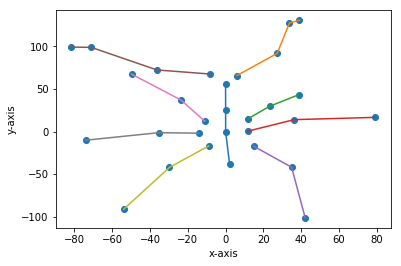

In [3]:
# FRAME ROTATION & TRANSLATION
# *** For Translational and Rotational Invariance ***
def Rotate(data, angle):
    # data - 2 x n || angle - 1 || output - 2 x n
    return np.einsum('ijk,jk ->ik', np.array([[np.cos(angle), -1*np.sin(angle)],
                                             [np.sin(angle), np.cos(angle)]]), data)
# def Rotate2(data, angle):
#     # data - 30 x 2 x t || Rot_Matrix - 2 x 2 || angle - 1 || output - 30 x 3 x t
#     return np.einsum('ijlk,jj ->ijk',np.expand_dims(data, axis=2),np.array([[np.cos(angle), -1*np.sin(angle)], [np.sin(angle), np.cos(angle)]])).T

def graph():
    # ORIGINAL DATA
    t = 700
    time_dp = data[:,:,t]
    plt.figure()
    plt.scatter(time_dp[:,0], time_dp[:,1])
    plt.plot(time_dp[0:4,0], time_dp[0:4,1]) # BODY AXIS
    plt.plot(time_dp[4:8,0], time_dp[4:8,1]) # RIGHT ANTENNAE
    plt.plot(time_dp[8:11,0], time_dp[8:11,1]) # RIGHT FRONT LEG
    plt.plot(time_dp[11:14,0], time_dp[11:14,1]) # RIGHT MIDDLE LEG
    plt.plot(time_dp[14:17,0], time_dp[14:17,1]) # RIGHT BACK LEG
    plt.plot(time_dp[17:21,0], time_dp[17:21,1]) # LEFT ANTENNAE
    plt.plot(time_dp[21:24,0], time_dp[21:24,1]) # LEFT FRONT LEG
    plt.plot(time_dp[24:27,0], time_dp[24:27,1]) # LEFT MIDDLE LEG
    plt.plot(time_dp[27:30,0], time_dp[27:30,1]) # LEFT BACK LEG
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()
    pass
    
# FORMATING DATA
time_length = len(df_data) # t
data = np.swapaxes(df_data.reshape((time_length,30,3)).T,0,1) # 30 x 3 x t
# graph()

# MAKE POINT 2 ORIGIN
data[:,0:2,:] = data[:,0:2,:] - data[2,0:2,:]
# graph()

# COMPUTE THE CENTER OF AXIS & ANGLE
axis_vector = data[1,:,:]
axis_angle_deviation = np.sign(axis_vector[0,:])*np.pi/2-np.arctan(axis_vector[1,:]/axis_vector[0,:])

# ROTATE ALL DATA POINT
for i in range(30):
    data[i,0:2,:] = Rotate(data[i,0:2,:], axis_angle_deviation)
# data[:,0:2,:] = Rotate2(data[:,0:2,:], axis_angle_deviation)

graph()

In [4]:
# PCA Analysis
# ***********************
# TAKE OUT POINT 2 B/C THIS IS ALWAYS FIXED
data_PCA1 = np.delete(data[:,0:2,:],2,0)
# SUBTRACT MEAN FROM DATA AND SCALE
data_PCA1 = data_PCA1.reshape((58, data.shape[2])) # 58 x t
data_PCA1 = data_PCA1 - np.expand_dims(np.mean(data_PCA1, axis=1), axis=1)
data_PCA1 = data_PCA1/np.expand_dims(np.std(data_PCA1, axis=1), axis=1)
# COMPUTE COVARIANCE
data_cov = np.cov(data_PCA1)
# PCA ANALYSIS
pca = PCA(n_components=26).fit(data_PCA1) #*** 26 Seems to be the cutoff based on the Eigenvalue Threshold ***
print("Principle Component Size: " + str(pca.components_.shape))
print("PC Explained Variance: " + str(pca.explained_variance_))
print("PC Explained Ratio: " + str(pca.explained_variance_ratio_))
print("Total PC Explained Ratio: " + str(np.sum(pca.explained_variance_ratio_)* 100)+"%")
print("PC Singular Values: " + str(pca.singular_values_))
print("PC Eigenvalues: " + str(pca.singular_values_**2))
# ***********************
# COMPUTING TRUNCATION POINT
# RANDOMIZE TIME INDEX
time_idx = np.arange(data_PCA1.shape[1])
rnd_time_idx = np.random.shuffle(time_idx)
data_rnd = data_PCA1[:,rnd_time_idx]
# COMPUTE COVARIANCE
data_rnd_cov = np.cov(data_PCA1)
# SVD TO CALCULATE LARGEST EIGENVALUE
pca_rnd = PCA(n_components=1).fit(data_rnd_cov)
print("Eigenvalue Threshold (Cutoff): " + str(pca_rnd.singular_values_.item()**2))

Principle Component Size: (26, 1252)
PC Explained Variance: [336.39815847 260.14350981  71.91014488  39.03274333  36.07097418
  27.03813679  25.23749547  22.45813938  20.42193794  19.74200325
  17.93729491  16.60084436  15.23895901  13.85998722  13.74750193
  12.53613481  12.0857242   11.29540301  10.48185756  10.14282708
   8.79402813   7.98625894   7.55486943   7.22743545   6.94292923
   6.34022233]
PC Explained Ratio: [0.30188107 0.23345074 0.0645316  0.03502768 0.03236981 0.02426381
 0.02264793 0.02015376 0.01832649 0.01771632 0.01609679 0.01489747
 0.01367532 0.01243784 0.0123369  0.01124983 0.01084563 0.01013641
 0.00940634 0.00910209 0.00789169 0.00716681 0.00677968 0.00648584
 0.00623053 0.00568967]
Total PC Explained Ratio: 93.07980428176919%
PC Singular Values: [138.47272306 121.77101486  64.02248244  47.16848916  45.34363823
  39.25778645  37.92805349  35.77868003  34.11818375  33.54540483
  31.97539382  30.76114641  29.47237119  28.10728147  27.99299216
  26.73124921  26.24

In [172]:
class MorletTrans:
    def __init__(self, w_0, N_f, f_min, f_max, fr=50):
        self.w_0 = w_0
        self.N_f = N_f
        self.f_min = f_min
        self.f_max = f_max
        self.f_array = self.freq(np.arange(1, N_f+1))
        self.fr = fr
        self.data_length = 1000 # Random length initially
    def morlet(self, eta):
        return np.pi**(-0.25)*np.exp(1j*self.w_0*eta)*np.exp(-0.5*eta**2)
    def s(self, f):
        return (self.w_0+np.sqrt(2+self.w_0**2))/(4*np.pi*f)
    def freq(self, i):
        return self.f_max*2**(-1*(i-1)/(self.N_f-1)*np.log2(self.f_max/self.f_min))
    def C(self, s_cons):
        return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(((self.w_0-np.sqrt(self.w_0**2+2))**2)/4)
        # return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(1/(((self.w_0-np.sqrt(self.w_0**2+2))**2)*4))
    def run(self, data):
        num_bp = data.shape[0]
        num_t = data.shape[-1]
        self.data_length = num_t
        num_dim = data.shape[1]
        t = np.arange(num_t)
        power = np.zeros((num_bp, num_dim, self.f_array.size, num_t)) 
        for bp_i, bp in enumerate(tqdm(range(num_bp))):
            for axis in range(num_dim):
                if num_t % 2 == 0:
                    y = data[bp_i,axis,:-1] # if even
                else:
                    y = data[bp_i,axis,:] # if odd
                for f_idx, f in enumerate(self.f_array):
                    s_cons = self.s(f)
                    # CWT Transform
                    transform = (1/np.sqrt(s_cons))*np.convolve(y, self.morlet(t/s_cons), mode="same") 
                    power[bp_i,axis,f_idx,:] = (1/self.C(s_cons))*np.absolute(transform)
        return power
    
    def plot(self, power_bp, save_as_pdf, t_start=0, t_end=100, cmap="OrRd"):
        fig, axes = plt.subplots(power_bp.shape[0], power_bp.shape[1], figsize=(20,115)) # (height, width) 
        # CREATE SUBPLOT
        for bp_i in tqdm(range(power_bp.shape[0])):
            for axis in range(power_bp.shape[1]):
                mesh = axes[bp_i,axis].pcolormesh(power_bp[bp_i,axis,:,t_start:t_end])# , edgecolors='face', linewidths=5
                axes[bp_i,axis].set_title("Wavelet Spectrogram Body Part " + str(bp_i) + " with Axis " + str(axis))
                axes[bp_i,axis].set_xlabel("Time (s)")
                axes[bp_i,axis].set_ylabel("Frequency (Hz)")
                # axes[bp_i,axis].set_yticklabels(np.around(self.f_array, decimals=2), minor=False)
                # fig.colorbar(mesh)
        plt.tight_layout()
        plt.show()
        # SAVE FIGURE AS PDF
        if(save_as_pdf == True):
            f = open("fig/" + 'RENAME_ME' + ".pdf","x")
            fig.savefig("fig/" + 'RENAME_ME' + ".pdf")
            f.close() 
        plt.close(fig)
        
        
#######################################################################################################################
#######################################################################################################################       
#         plt.imshow(power[:,t_start:t_end], cmap=cmap, vmax=abs(power).max(), vmin=0, 
#                    extent=[t_start, t_end, self.f_array[-1], self.f_array[0]],
#                    interpolation='nearest', aspect='auto')

In [169]:
print(np.around(MT.f_array, decimals=2))
print(MT.f_array[10])

[20.   17.65 15.58 13.75 12.14 10.71  9.46  8.35  7.37  6.5   5.74  5.07
  4.47  3.95  3.48  3.08  2.71  2.4   2.11  1.87  1.65  1.45  1.28  1.13
  1.  ]
5.740294369528561


100%|██████████| 30/30 [00:00<00:00, 220.37it/s]


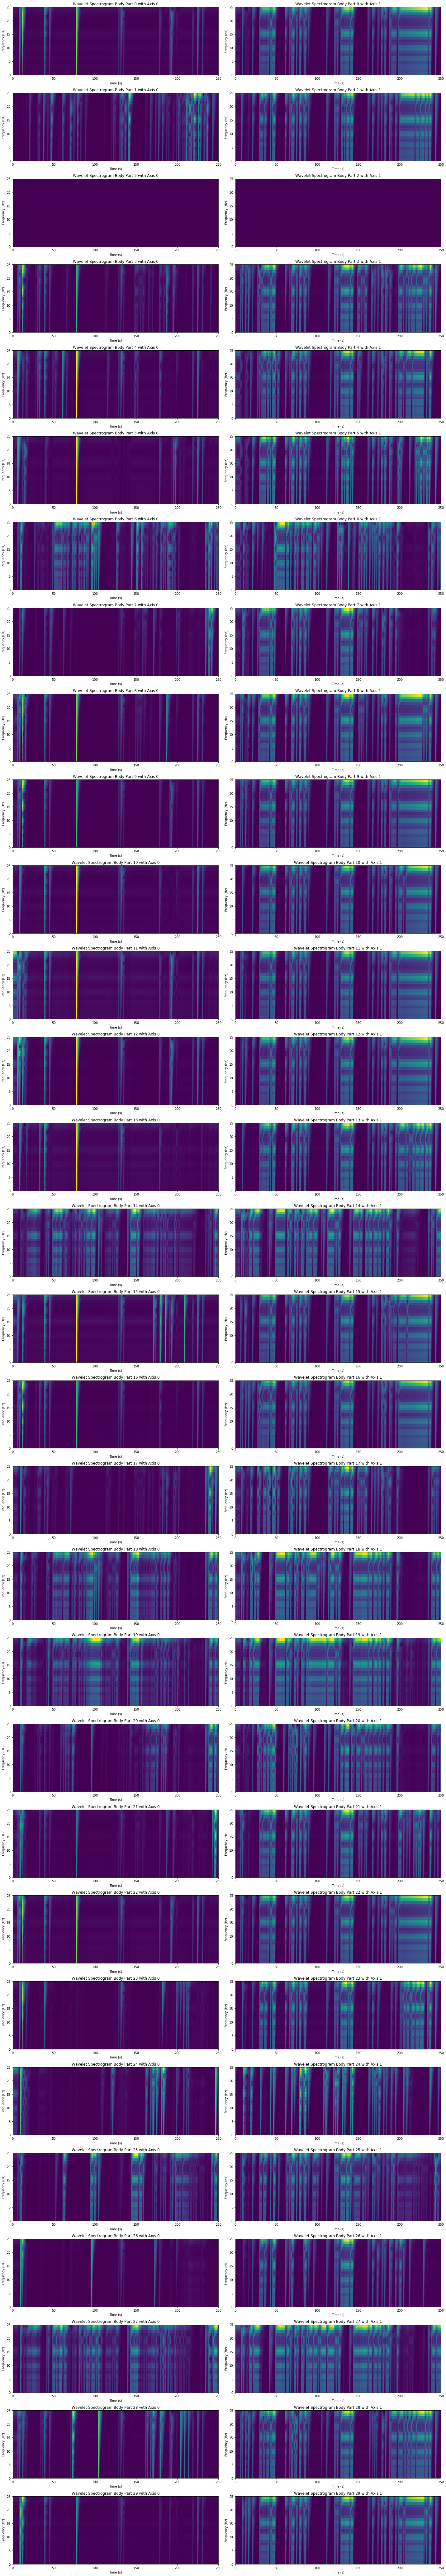

In [173]:
# MORLET TRANSFORM ON BODY PARTS
MT = MorletTrans(w_0=15, N_f=25, f_min=1, f_max=6, fr=50)
power_bp = MT.run(data[:,0:2,:])
MT.plot(power_bp, save_as_pdf=True, t_start=350, t_end=600)    

* $Framerate = 50Hz$
* Analyze frequency from $f_{min}=1Hz$ to $f_{max}=25Hz$
* $N_f = 25$ number of frequency bins
* These are the following frequencies analyzed: {{MT.f_array}}
* Power Spectrum should always be positive

 12%|█▏        | 3/26 [00:00<00:00, 25.80it/s]

PCA Shape: (26, 1252)


100%|██████████| 26/26 [00:00<00:00, 30.42it/s]


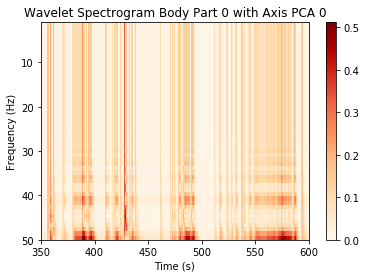

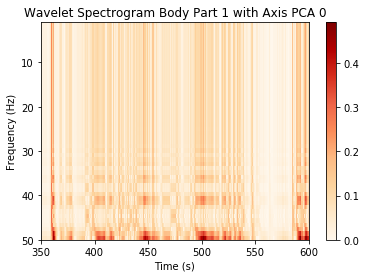

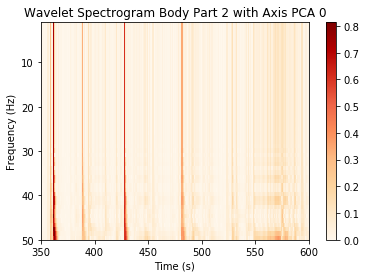

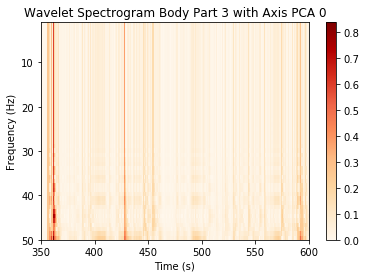

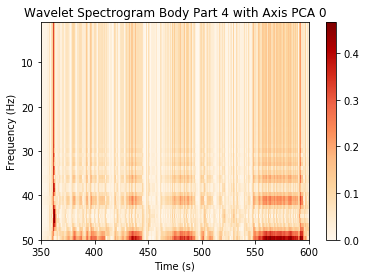

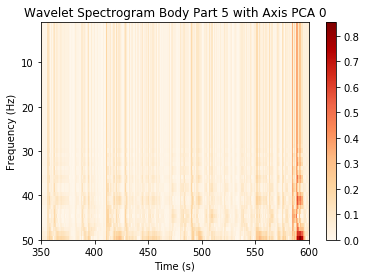

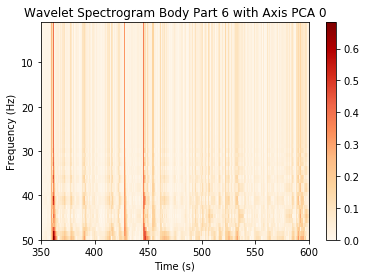

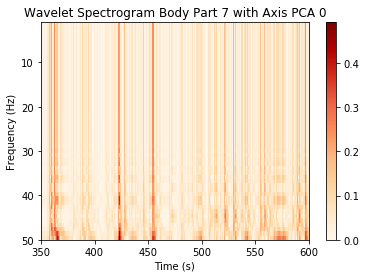

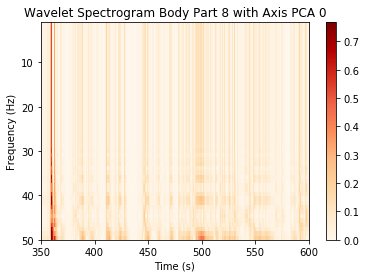

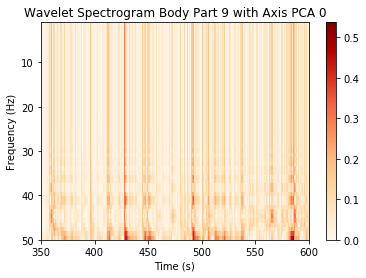

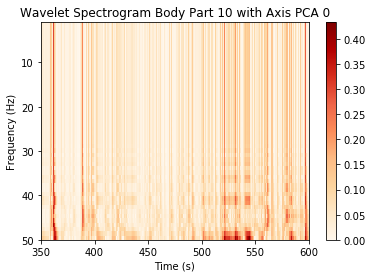

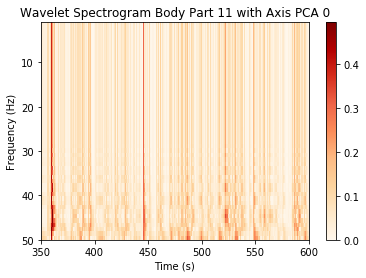

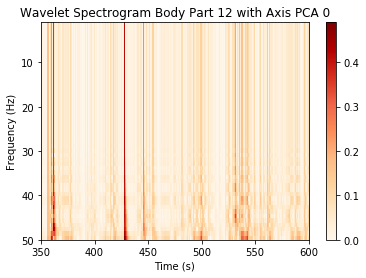

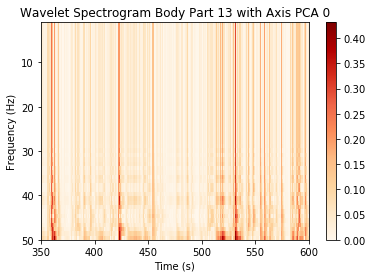

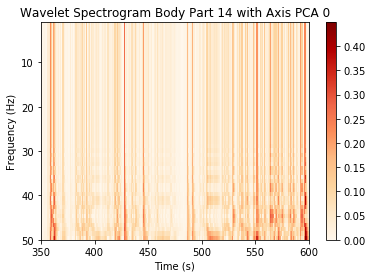

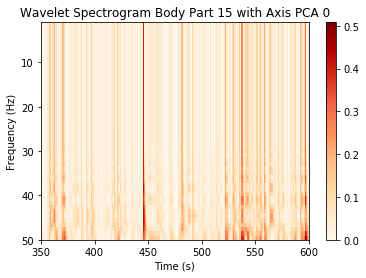

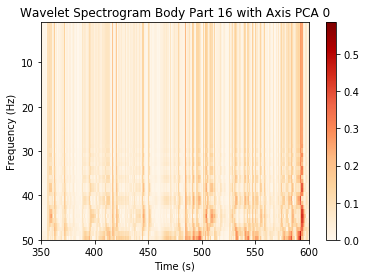

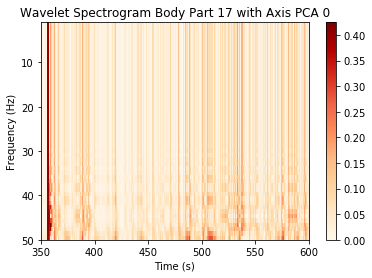

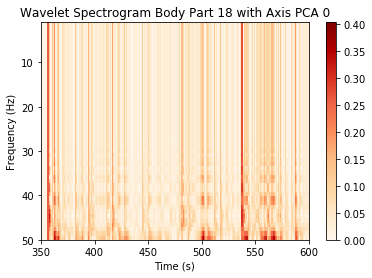

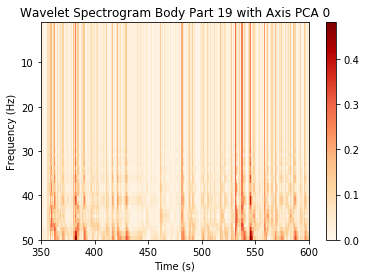

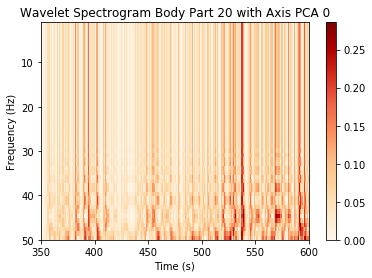

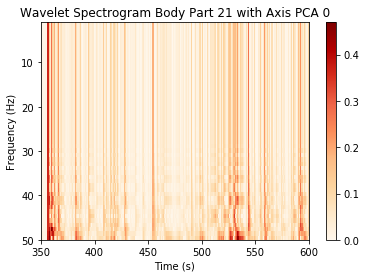

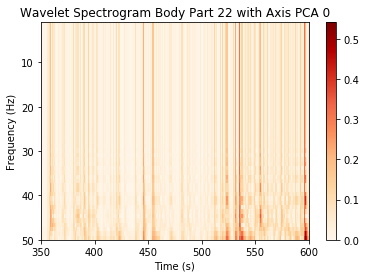

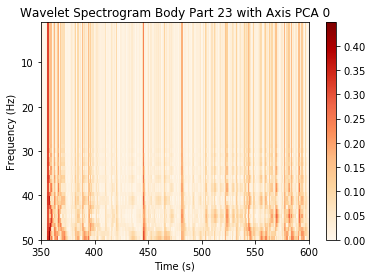

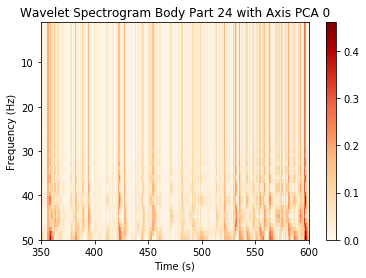

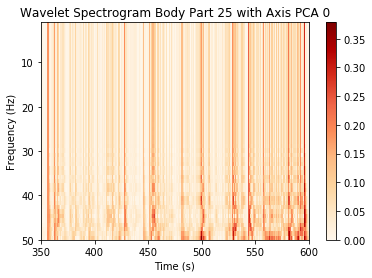

In [10]:
# MORLET TRANSFORM ON PCA
print("PCA Shape: " + str(pca.components_.shape))
MT = MorletTrans(w_0=15, N_f=50, f_min=1, f_max=50)
pca_data = np.expand_dims(pca.components_, axis=1) 
power_pca = MT.run(pca_data)
for comp_i in range(power_pca.shape[0]):
    for axis in range(power_pca.shape[1]):
        MT.plot(power_pca[comp_i,axis,:,:], 350, 600, 
                "Wavelet Spectrogram Body Part " + str(comp_i) + " with Axis PCA " + str(axis))

17it [00:03,  5.40it/s]


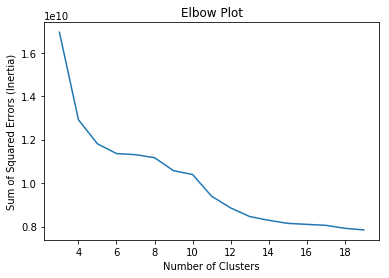

In [11]:
class KMeansCluster:
    def __init__(self, min_k, max_k, epoch=100, rand_seed=0):
        self.min_k = min_k
        self.max_k = max_k
        self.epoch = epoch
        self.rand_seed = rand_seed
        self.k_array = np.arange(min_k,max_k)
        self.sse = np.zeros(self.k_array.shape[0])
    def run(self, data_cluster):
        for k_i, k in tqdm(enumerate(self.k_array)):
            k_means = cluster.KMeans(n_clusters=k, init='random', n_init=self.epoch,
                                    random_state=self.rand_seed).fit(data_cluster)
            self.sse[k_i] = k_means.inertia_
    def plot(self):
        plt.plot(self.k_array, self.sse)
        plt.title('Elbow Plot')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Sum of Squared Errors (Inertia)')
        plt.show()
        
# FORMAT DATA
data_cluster = power_bp.reshape((3000,power_bp.shape[-1])).T
# Run K-Means Cluster
kmeans = KMeansCluster(min_k=3,max_k=80,epoch=50,rand_seed=0) # * NEED MORE DATA POINTS!
kmeans.run(data_cluster)
kmeans.plot()

0it [00:00, ?it/s]

DATA SHAPE: (1252, 3000)


/Users/donghur/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
28it [05:02, 10.81s/it]


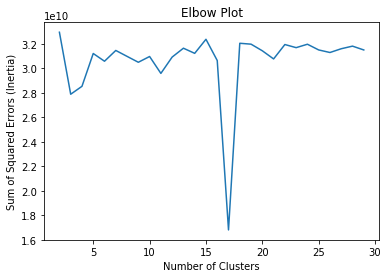

In [12]:
class SpectralClustering: 
    def __init__(self, min_k, max_k, epoch=100, rand_seed=0):
        self.min_k = min_k
        self.max_k = max_k
        self.epoch = epoch
        self.rand_seed = rand_seed
        self.k_array = np.arange(min_k, max_k)
        self.sse = np.zeros(self.k_array.shape[0])
        
    def run(self, data):
        for k_i, k in tqdm(enumerate(self.k_array)):
            SCluster = cluster.SpectralClustering(n_clusters=k, n_init=self.epoch, assign_labels="kmeans", random_state=self.rand_seed).fit(data)
            self.sse[k_i] = self.computeSSE(SCluster.labels_, data)
        return SCluster.affinity_matrix_
        # YOU CAN ALSO RETURN SCluster.affinity_matrix_
    def computeSSE(self, label, data):
        # FIND MAX NUMBER OF CLUSTER
        max_cluster = np.amax(label)
        sse = 0
        for c in range(max_cluster):
            c_idx = np.where(label == c)[0]
            c_data = data[c_idx,:]
            data_mean = np.mean(c_data, axis=0)
            sse += np.sum((c_data-data_mean)**2)
        return sse
    def plot(self):
        plt.plot(self.k_array, self.sse)
        plt.title('Elbow Plot')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Sum of Squared Errors (Inertia)')
        plt.show()
        pass
    
data_cluster = power_bp.reshape((3000, power_bp.shape[-1])).T
print("DATA SHAPE: " + str(data_cluster.shape))
SCluster = SpectralClustering(2, 80, 1000, 0)
SCluster_affinity = SCluster.run(data_cluster)
SCluster.plot()

### plt.imshow(SCluster_affinity)
### plt.show()
I THINK THIS OCCURS BECAUSE THE DATA IS SO SPARSE SO THE DISTANCE BETWEEN SOME OF THE NODES IS TOO BIG. THE AFFINITY
IS THE EXPONENTIAL OF THE - DISTANCE. IF DISTANCE IS REALLY BIG, THEN THE AFFINITY IS ALMOST ZERO

# VERIFYING ANALYTICAL MORLET CONTINUOUS WAVELET TRANSFORM

[25.         11.18033989  5.        ]


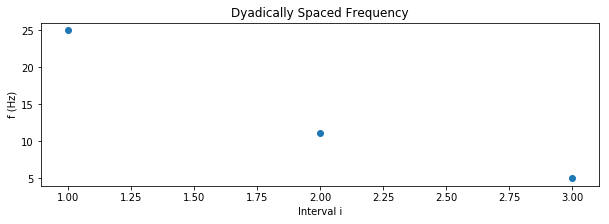

In [176]:
# Frequency points of analysis
f_min = 5
f_max = 25
N_f = 3
i = np.arange(1, N_f+1)
f_i = f_max*2**(-1*(i-1)/(N_f-1)*np.log2(f_max/f_min))
print(f_i)
plt.scatter(i,f_i)
plt.xlabel("Interval i")
plt.ylabel("f (Hz)")
plt.title("Dyadically Spaced Frequency")
plt.show()

Dyadically spaced frequency. As you can see the frequency decrease for each interval i is not linear but exponential.

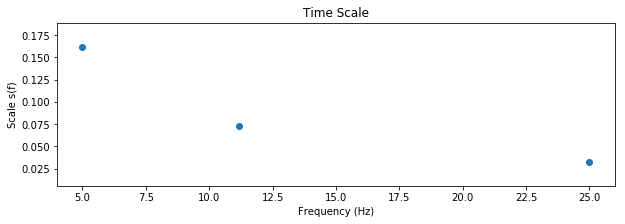

In [177]:
# Time Scale factor (stretching or squeezing of wavelet)
def s(f):
    w_0 = 5 # Non-Dimensional Parameter
    return (w_0+np.sqrt(2+w_0**2))/(4*np.pi*f)
plt.scatter(f_i,s(f_i))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Scale s(f)")
plt.title("Time Scale")
plt.show()

Note how frequency and scales are inversely proportinal. As scale increase (s>1), the frequency is low, thus capturing slowly varying changes. As the scale decreases (0<s<1), frequency increases, which allows fro capturing of abrupt changes.

/Users/donghur/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


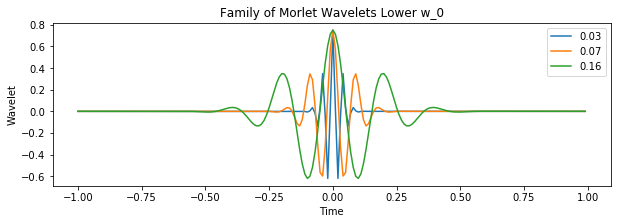

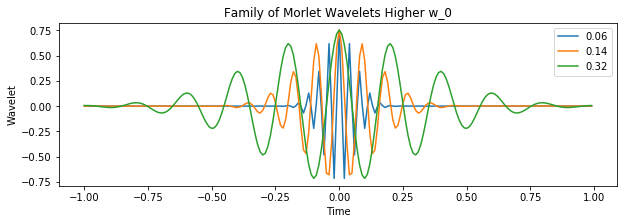

In [178]:
# Time Scale factor (stretching or squeezing of wavelet)
w_0 = 5 # Non-Dimensional Parameter
def s(f):
    return (w_0+np.sqrt(2+w_0**2))/(4*np.pi*f)

# Morlet Wave Generation
def morlet(eta):
    return np.pi**(-0.25)*np.exp(1j*w_0*eta)*np.exp(-0.5*eta**2)

t = np.arange(-1,1, 0.01)
tau = 0

for s_i in s(f_i):
    wavelet = morlet((t-tau)/s_i)
    plt.plot(t, wavelet)
plt.xlabel("Time")
plt.ylabel("Wavelet")
plt.title("Family of Morlet Wavelets Lower w_0")
plt.legend(np.round(s(f_i),2))
plt.show()
###############################################
###############################################
w_0 = 10 # Non-Dimensional Parameter
t = np.arange(-1,1, 0.01)
tau = 0

for s_i in s(f_i):
    wavelet = morlet((t-tau)/s_i)
    plt.plot(t, wavelet)
plt.xlabel("Time")
plt.ylabel("Wavelet")
plt.title("Family of Morlet Wavelets Higher w_0")
plt.legend(np.round(s(f_i),2))
plt.show()

Notice how an increase in w_0 causes a stretch in the wavelet. However, most importantly, an increase in w_0 role is to increase the number of exposed sinusoidal function before tapering off by the Gaussian Filter. Also note how the frequency decreases from blue -> orange -> green as the scale factor increases like we expected from the previous analysis.

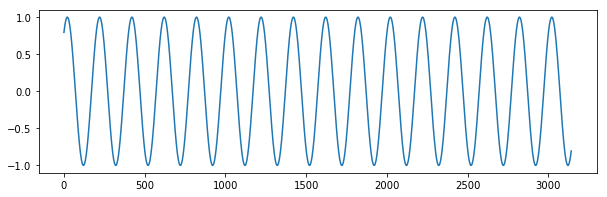

Signal Frequency: 5
Signal Length: 3142


/Users/donghur/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


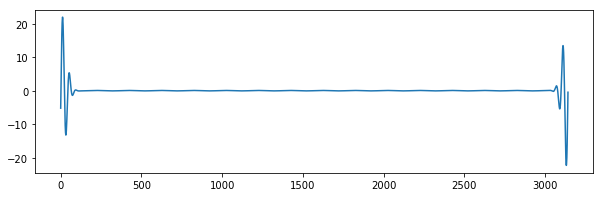

Wavelet Scale: 0.0324553611718433
Wavelet Frequency: 25.0


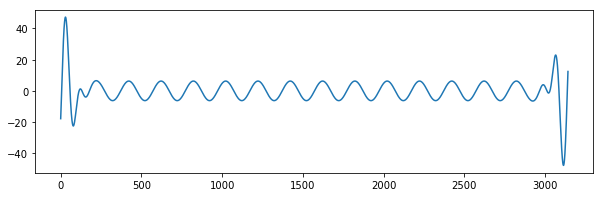

Wavelet Scale: 0.07257239381454884
Wavelet Frequency: 11.180339887498949


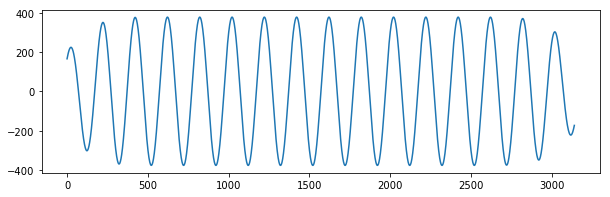

Wavelet Scale: 0.16227680585921647
Wavelet Frequency: 5.000000000000001


In [179]:
# MORLET TRANSFORM
w_0 = 5 # Non-Dimensional Parameter
def w(y, s_i):
    return (1/np.sqrt(s_i))*np.convolve(y, morlet((t-tau)/s_i), mode="same")
def s(f):
    return (w_0+np.sqrt(2+w_0**2))/(4*np.pi*f)
def morlet(eta):
    return np.pi**(-0.25)*np.exp(1j*w_0*eta)*np.exp(-0.5*eta**2)

t = np.arange(-0.5*np.pi,0.5*np.pi, 0.001)
tau = 0
sig_freq = 5
y = np.sin(np.pi*2*sig_freq*t)

plt.plot(y)
plt.show()
print("Signal Frequency: "+ str(sig_freq))
print("Signal Length: "+ str(y.size))
for s_i in s(f_i):
    wavelet_trans = w(y, s_i)
    plt.plot(wavelet_trans)
    plt.show()
    print("Wavelet Scale: " + str(s_i))
    print("Wavelet Frequency: " + str(s(s_i)))


Notice how the Morlet transform is the largest when the frequency of the wavelet and the frequency of the signals are the same

/Users/donghur/.local/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


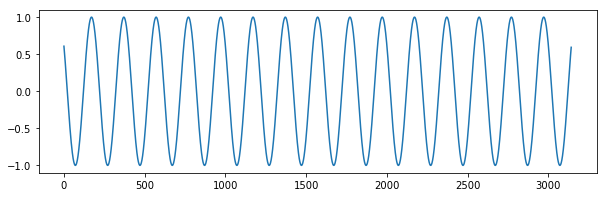

Signal Frequency: 5
Signal Length: 3142


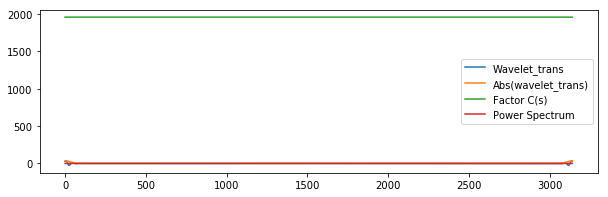

Wavelet Scale: 0.0324553611718433
Wavelet Frequency: 25.0
Factor C: 1956.248760219124


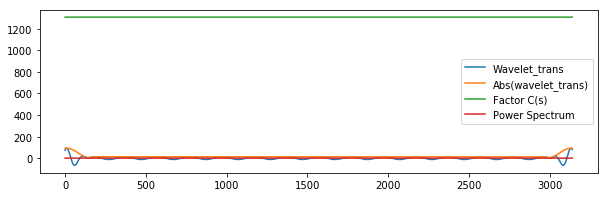

Wavelet Scale: 0.07257239381454884
Wavelet Frequency: 11.180339887498949
Factor C: 1308.2223925186847


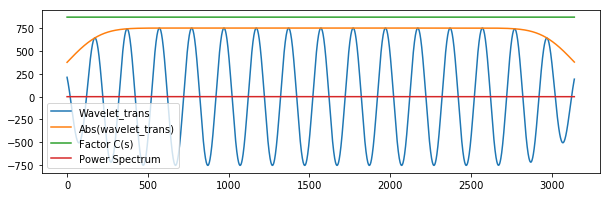

Wavelet Scale: 0.16227680585921647
Wavelet Frequency: 5.000000000000001
Factor C: 874.8610417499297


In [180]:
# MORLET TRANSFORM TIMES A CONSTANT TO COMPUTE THE POWER SPECTRUM
w_0 = 5 # Non-Dimensional Parameter
def w(y, s_i):
    return (1/np.sqrt(s_i))*np.convolve(y, morlet((t-tau)/s_i), mode="same")
def s(f):
    return (w_0+np.sqrt(2+w_0**2))/(4*np.pi*f)
def morlet(eta):
    return np.pi**(-0.25)*np.exp(1j*w_0*eta)*np.exp(-0.5*eta**2)
def C(s_cons):
    #return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(((w_0-np.sqrt(w_0**2+2))**2)/4)
    return ((np.pi**(-0.25))/np.sqrt(2*s_cons))*np.exp(1/(((w_0-np.sqrt(w_0**2+2))**2)*4))

t = np.arange(-0.5*np.pi,0.5*np.pi, 0.001)
tau = 0
sig_freq = 5
# y = np.sin(np.pi*2*sig_freq*t)
y = np.exp(2*np.pi*1j*sig_freq*t) # Essentially a sine wave with an imaginary component
plt.plot(y)
plt.show()
print("Signal Frequency: "+ str(sig_freq))
print("Signal Length: "+ str(y.size))

for s_i in s(f_i):
    wavelet_trans = w(y, s_i)
    factor = C(s_i)
    plt.plot(wavelet_trans)
    plt.plot(np.absolute(wavelet_trans))
    plt.plot(np.ones(wavelet_trans.size)*factor)
    power_spectrum = (1/factor)*np.absolute(wavelet_trans)
    plt.plot(power_spectrum)
    plt.legend(["Wavelet_trans",  "Abs(wavelet_trans)","Factor C(s)", "Power Spectrum"])
    plt.show()
    
    print("Wavelet Scale: " + str(s_i))
    print("Wavelet Frequency: " + str(s(s_i)))
    print("Factor C: " + str(factor))

Notice how there is a straight line for the absolute value of the wave transform. This is because there is an imaginary component, and the root sum squared with the real and imaginary component will lead to a constant value. The scalar function C(s) is too compensate for the disproportionally large value of the signal transform to pure sine waves of lower freqeuncies. You can see this in the graph, how the green line is lower than the orange line

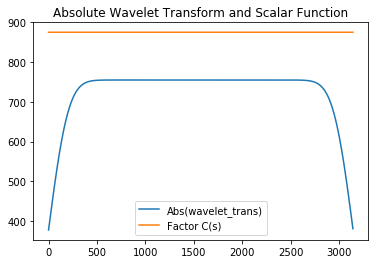

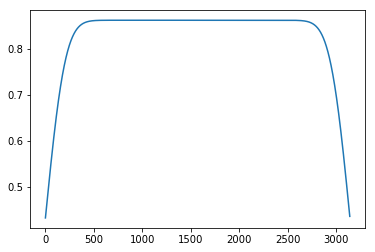

In [79]:
plt.plot(np.absolute(wavelet_trans))
plt.plot(np.ones(wavelet_trans.size)*C(s_i))
plt.title("Absolute Wavelet Transform and Scalar Function")
plt.legend(["Abs(wavelet_trans)","Factor C(s)"])
plt.show()
plt.plot(power_spectrum)
plt.show()
plt.title("Power Spectrum")

The purpose of the last 3 figures is to prove the sclar function C(s). Notice how the by dividing by the constant scalar function the power spectrum is approximately 1, which is what we wanted if the signal was pure sine waves.

# TODO:
* Check Scalar function C(s)
* Find out what your nyquist Frequency should be
* Your data after frame 700 is weird

# TESTING SPECTRAL CLUSTERING

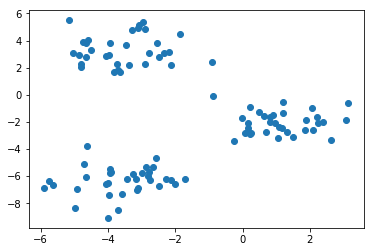

20it [00:00, 81.84it/s]


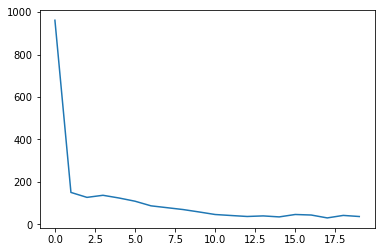

In [13]:
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.datasets import make_blobs

X, clusters = make_blobs(n_samples=100, random_state=60)
# X = np.array([[1, 1], [2, 1], [1, 0],
#                [4, 7], [3, 5], [3, 6]])
plt.scatter(X[:,0], X[:,1])
plt.show()

sse = np.zeros(20)

for k_i, k in tqdm(enumerate(np.arange(2,22))):
    clustering = SpectralClustering(n_clusters=k,
             assign_labels="discretize",
             random_state=0).fit(X)
    max_cluster = np.amax(clustering.labels_)
    temp=0
    for c in range(max_cluster):
        c_idx = np.where(clustering.labels_ == c)[0]
        c_data = X[c_idx,:]
        data_mean = np.mean(c_data, axis=0)
        sse[k_i] += np.sum((c_data-data_mean)**2)
    
plt.plot(sse)
plt.show()